We are making clusters out of the embedded data. These clusters represent the data of each individual for categorization purposes

In [18]:
import numpy as np
import cv2 as cv
import mediapipe as mp
import os

# extract_frames: function that takes a video file path and extracts frames from the video.
# params
# video_file_path:   the path to the video file
# video_name:        the name of the video file
# sample_every:      the number of frames to skip between samples
# return:            a list of frames extracted from the video

def extract_frames(video_file_path, video_name, sample_every):
  print('Start extracting frames')
  frame_list = []
  video_path = os.path.join(video_file_path, video_name)
  cap = cv.VideoCapture(video_path)
  if not cap.isOpened():
    print("Error: Cannot open video file.")
    return []
  i = 0
  captured = 0
  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break
    if i % sample_every == 0:
      frame_rgb = np.ascontiguousarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
      mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
      frame_list.append(mp_image)
      captured += 1
    i += 1
  cap.release()
  cv.destroyAllWindows()
  print(f"Successfully captured {captured} frames")
  return frame_list

# save_face_list: function that takes a list of faces and saves them to a folder.
# params
# face_list_movie:    the list of faces to be saved
# faces_folder:       the folder to save the faces
# movie:              the name of the movie
# extension:          the extension of the saved faces
# return:             None

def save_face_list(face_list_movie,faces_folder,movie,extension):
  saved_faces = 0
  for i, face in enumerate(face_list_movie):
      if face.shape[0] > 10 and face.shape[1] > 10:
          cv.imwrite(faces_folder + movie + '_' + str(saved_faces) + extension, face)
          saved_faces += 1
  return

In [19]:
import cv2
cap = cv2.VideoCapture("C:\\Users\\ningw\\Desktop\\Test.mp4")
if not cap.isOpened():
    print("Error: Cannot open video file.")
else:
    print("Video file opened successfully!")
cap.release()


Video file opened successfully!


In [20]:
import numpy as np
import cv2 as cv
from utils import save_face_list, extract_frames
from face_extraction import process_image, check_face
from facenet_pytorch import MTCNN
import torch

MOVIE_FOLDER = "C:\\Users\\ningw\\Desktop"
FRAME_FOLDER = "C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3"
FACES_FOLDER_TRAINING = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder\\'
FACES_FOLDER_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder_test\\'
MOVIE_TRAINING_LIST = ['New Kids ABC','New Kids Fussballspiel','New Kids Turbo_ Tankstation']
MOVIE_TEST_LIST = ['Test']

output_extension= '.png'
input_extension = '.mp4'
samples_per_second = 10         #FPS rate is assumed 25
padding_x = 10
padding_y = 10
min_confidence = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

for movie in MOVIE_TRAINING_LIST:
  print(movie+input_extension)
  frame_list = extract_frames(MOVIE_FOLDER,movie+input_extension,samples_per_second)
  face_list_movie = []
  for frame in frame_list:
    face_list_frame = process_image(frame,padding_x,padding_y,min_confidence)
    for face in face_list_frame:
      if check_face(face,mtcnn):
        face_list_movie.append(face)
  print('saving')
  save_face_list(face_list_movie,FACES_FOLDER_TRAINING,movie,output_extension)

New Kids ABC.mp4
Start extracting frames
Successfully captured 204 frames
saving
New Kids Fussballspiel.mp4
Start extracting frames
Successfully captured 464 frames
saving
New Kids Turbo_ Tankstation.mp4
Start extracting frames
Successfully captured 440 frames
saving


In [21]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path  # import Path from pathlib module
from embed import embed_face_net


FACES_FOLDER_TRAINING = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder\\'
OUTPUT_FOLDER_RESULTS = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results\\'
RESULTS_NAME = 'second_results.csv'
directory = Path(FACES_FOLDER_TRAINING)


vector_embedding = dict()
for file in directory.iterdir():  
  if file.is_file():
    file_name = file.name  
    print(file_name)
    path = FACES_FOLDER_TRAINING + file_name
    img = cv2.imread(path)
    vector = embed_face_net(img)
    vector_np = vector.detach().numpy()
    vector_embedding[file.name] = vector_np.flatten()
    
embedding_df = pd.DataFrame(vector_embedding)
print(embedding_df.shape)

embedding_df.to_csv(OUTPUT_FOLDER_RESULTS+RESULTS_NAME, index=False)

New Kids ABC_0.png
New Kids ABC_1.png
New Kids ABC_10.png
New Kids ABC_100.png
New Kids ABC_101.png
New Kids ABC_102.png
New Kids ABC_103.png
New Kids ABC_104.png
New Kids ABC_105.png
New Kids ABC_106.png
New Kids ABC_11.png
New Kids ABC_12.png
New Kids ABC_13.png
New Kids ABC_14.png
New Kids ABC_15.png
New Kids ABC_16.png
New Kids ABC_17.png
New Kids ABC_18.png
New Kids ABC_19.png
New Kids ABC_2.png
New Kids ABC_20.png
New Kids ABC_21.png
New Kids ABC_22.png
New Kids ABC_23.png
New Kids ABC_24.png
New Kids ABC_25.png
New Kids ABC_26.png
New Kids ABC_27.png
New Kids ABC_28.png
New Kids ABC_29.png
New Kids ABC_3.png
New Kids ABC_30.png
New Kids ABC_31.png
New Kids ABC_32.png
New Kids ABC_33.png
New Kids ABC_34.png
New Kids ABC_35.png
New Kids ABC_36.png
New Kids ABC_37.png
New Kids ABC_38.png
New Kids ABC_39.png
New Kids ABC_4.png
New Kids ABC_40.png
New Kids ABC_41.png
New Kids ABC_42.png
New Kids ABC_43.png
New Kids ABC_44.png
New Kids ABC_45.png
New Kids ABC_46.png
New Kids ABC_47.pn

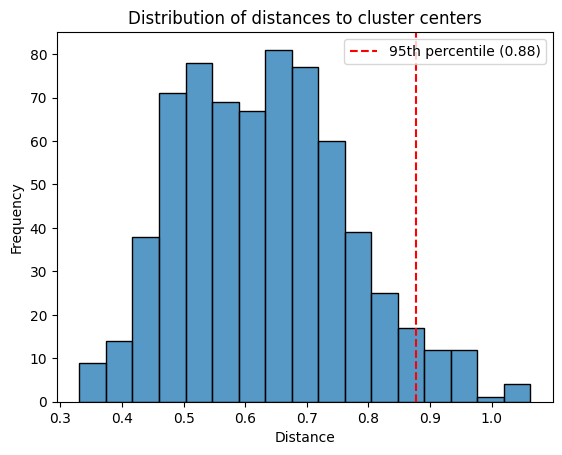

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, pairwise_distances_argmin_min
import os
import shutil
import joblib
import seaborn as sns
import numpy as np


# find_best_number_of_clusters: function that takes a csv file with embeddings and finds the best number of clusters for KMeans clustering.
# params
# results_csv:       the csv file with the embeddings
# min_clusters:      the minimum number of clusters to test
# max_clusters:      the maximum number of clusters to test
# return:            the best number of clusters based on silhouette score and calinski-harabasz score

def find_best_number_of_clusters(results_csv, min_clusters=2, max_clusters=15):
    embeddings_df = pd.read_csv(results_csv)
    embeddings = embeddings_df.T.values
    best_silhouette_score = -1
    best_calinski_score = -1
    best_n_clusters_silhouette = min_clusters
    best_n_clusters_calinski = min_clusters
    silhouette_scores = []
    calinski_scores = []

    if not os.path.exists('Plots'):
        os.makedirs('Plots')
    if not os.path.exists('KMEANS_OUTPUT'):
        os.makedirs('KMEANS_OUTPUT')

    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(embeddings, labels)
        calinski_avg = calinski_harabasz_score(embeddings, labels)
        silhouette_scores.append(silhouette_avg)
        calinski_scores.append(calinski_avg)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_n_clusters_silhouette = n_clusters

        if calinski_avg > best_calinski_score:
            best_calinski_score = calinski_avg
            best_n_clusters_calinski = n_clusters

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette Score')
    plt.axvline(x=best_n_clusters_silhouette, color='r', linestyle='--', label=f'Best Clustering ({best_n_clusters_silhouette})')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.legend()
    plt.title('Silhouette score vs number of clusters')

    plt.subplot(1, 2, 2)
    plt.plot(range(min_clusters, max_clusters + 1), calinski_scores, marker='o', label='Calinski-Harabasz Score')
    plt.axvline(x=best_n_clusters_calinski, color='r', linestyle='--', label=f'Best Clustering ({best_n_clusters_calinski})')
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski-Harabasz score')
    plt.legend()
    plt.title('Calinski-Harabasz score vs number of clusters')

    plt.tight_layout()
    plt.savefig('Plots/clustering_scores.png')
    plt.show()

    return best_n_clusters_silhouette, best_n_clusters_calinski


# separate_images_by_clusters: function that takes a csv file with embeddings and separates the images into clusters based on KMeans clustering.
# params
# results_csv:          the csv file with the embeddings
# faces_folder:         the folder with the images
# output_base_folder:   the folder to save the clustered images
# n_clusters:           the number of clusters to use
# thresholdperentile:   the percentile to use for the threshold distance
# return:               None
def separate_images_by_clusters(results_csv, faces_folder, output_base_folder, n_clusters=2, thresholdperentile=95):
    embeddings_df = pd.read_csv(results_csv)
    embeddings = embeddings_df.T.values

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
    joblib.dump(kmeans, os.path.join(output_base_folder, 'kmeans.pkl'))
    labels = kmeans.labels_

    distances = pairwise_distances_argmin_min(embeddings, kmeans.cluster_centers_,metric='euclidean' )[1]
    threshold_distance = np.percentile(distances, thresholdperentile)

    sns.histplot(distances)
    plt.axvline(threshold_distance, color='r', linestyle='--', label=f'95th percentile ({threshold_distance:.2f})')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of distances to cluster centers')
    plt.savefig('Plots/clusertering_distances.png')
    plt.show()

    for i, file_name in enumerate(embeddings_df.columns):
        src_path = os.path.join(faces_folder, file_name)
        if distances[i] > threshold_distance:
            dst_path = os.path.join(output_base_folder, 'outliers', file_name)
        else:
            dst_path = os.path.join(output_base_folder, f'cluster_{labels[i]}', file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

RESULTS_CSV = 'results\\second_results.csv'
FACES_FOLDER = 'face_folder\\'
OUTPUT_BASE_FOLDER = 'KMEANS_OUTPUT'

best_clusters_silhouette, best_clusters_calinski = find_best_number_of_clusters(RESULTS_CSV)
separate_images_by_clusters(RESULTS_CSV, FACES_FOLDER, OUTPUT_BASE_FOLDER, n_clusters=best_clusters_silhouette, thresholdperentile=95)

In [23]:
for movie in MOVIE_TEST_LIST:
  print(movie+input_extension)
  frame_list = extract_frames(MOVIE_FOLDER,movie+input_extension,samples_per_second)
  face_list_movie = []
  for frame in frame_list:
    face_list_frame = process_image(frame,padding_x,padding_y,min_confidence)
    for face in face_list_frame:
      if check_face(face,mtcnn):
        face_list_movie.append(face)
  print('saving')
  save_face_list(face_list_movie,FACES_FOLDER_TEST,movie,output_extension)

Test.mp4
Start extracting frames
Successfully captured 104 frames
saving


In [24]:
FACES_FOLDER_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder_test\\'
OUTPUT_FOLDER_RESULTS = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results_test\\'
RESULTS_NAME = 'test_results.csv'
directory = Path(FACES_FOLDER_TEST)


vector_embedding = dict()
for file in directory.iterdir():  
  if file.is_file():
    file_name = file.name  
    print(file_name)
    path = FACES_FOLDER_TEST + file_name
    img = cv2.imread(path)
    vector = embed_face_net(img)
    vector_np = vector.detach().numpy()
    vector_embedding[file.name] = vector_np.flatten()
    
embedding_df = pd.DataFrame(vector_embedding)
print(embedding_df.shape)

embedding_df.to_csv(OUTPUT_FOLDER_RESULTS+RESULTS_NAME, index=False)

Test_0.png
Test_1.png
Test_10.png
Test_11.png
Test_12.png
Test_13.png
Test_14.png
Test_15.png
Test_16.png
Test_17.png
Test_18.png
Test_19.png
Test_2.png
Test_20.png
Test_21.png
Test_22.png
Test_23.png
Test_24.png
Test_25.png
Test_26.png
Test_27.png
Test_28.png
Test_29.png
Test_3.png
Test_30.png
Test_31.png
Test_4.png
Test_5.png
Test_6.png
Test_7.png
Test_8.png
Test_9.png
(512, 32)


In [25]:
# Cell 1: Identify which cluster each image belongs to
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import joblib

# Define file paths
TEST_RESULTS_CSV = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results_test\\test_results.csv'
CLUSTER_MODEL_PATH = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\KMEANS_OUTPUT\\kmeans.pkl'

# Load test embeddings and KMeans model
test_embeddings_df = pd.read_csv(TEST_RESULTS_CSV)
test_embeddings = test_embeddings_df.T.values
kmeans = joblib.load(CLUSTER_MODEL_PATH)
cluster_centers = kmeans.cluster_centers_

# Match each image to a cluster
image_cluster_results = []
for i, embedding in enumerate(test_embeddings):
    distances = euclidean_distances([embedding], cluster_centers)
    closest_cluster = distances.argmin()
    image_cluster_results.append({
        "Image": test_embeddings_df.columns[i],
        "Cluster": closest_cluster
    })
    print(f"Image {test_embeddings_df.columns[i]} belongs to Cluster {closest_cluster}")

# Save image-to-cluster mapping
results_df = pd.DataFrame(image_cluster_results)
results_output_path = 'image_to_cluster_results.csv'
results_df.to_csv(results_output_path, index=False)
print(f"Image-to-cluster mapping saved at {results_output_path}")


Image Test_0.png belongs to Cluster 9
Image Test_1.png belongs to Cluster 6
Image Test_10.png belongs to Cluster 7
Image Test_11.png belongs to Cluster 7
Image Test_12.png belongs to Cluster 7
Image Test_13.png belongs to Cluster 3
Image Test_14.png belongs to Cluster 10
Image Test_15.png belongs to Cluster 3
Image Test_16.png belongs to Cluster 10
Image Test_17.png belongs to Cluster 7
Image Test_18.png belongs to Cluster 7
Image Test_19.png belongs to Cluster 7
Image Test_2.png belongs to Cluster 3
Image Test_20.png belongs to Cluster 7
Image Test_21.png belongs to Cluster 10
Image Test_22.png belongs to Cluster 3
Image Test_23.png belongs to Cluster 3
Image Test_24.png belongs to Cluster 3
Image Test_25.png belongs to Cluster 7
Image Test_26.png belongs to Cluster 3
Image Test_27.png belongs to Cluster 3
Image Test_28.png belongs to Cluster 10
Image Test_29.png belongs to Cluster 3
Image Test_3.png belongs to Cluster 6
Image Test_30.png belongs to Cluster 3
Image Test_31.png belongs

In [26]:
# Cell 2: Count how often each cluster has appeared (chronologically with missing clusters included)
from collections import Counter
import pandas as pd

# Load image-to-cluster mapping
image_to_cluster_path = 'image_to_cluster_results.csv'
image_cluster_results = pd.read_csv(image_to_cluster_path)

# Count the occurrences of each cluster
cluster_counts = Counter(image_cluster_results["Cluster"])

# Ensure all clusters from 0 to 11 are included, even if their count is 0
max_cluster = 11  # Adjust this number based on the maximum number of clusters
cluster_counts_complete = {cluster: cluster_counts.get(cluster, 0) for cluster in range(max_cluster + 1)}

# Print cluster appearance counts in chronological order
print("\nCluster Appearance Counts (Chronological Order):")
for cluster in range(max_cluster + 1):
    print(f"Cluster {cluster}: {cluster_counts_complete[cluster]} appearances")

# Save the counts to a CSV file
cluster_counts_df = pd.DataFrame(cluster_counts_complete.items(), columns=["Cluster", "Count"])
cluster_counts_output_path = 'cluster_appearance_counts.csv'
cluster_counts_df.to_csv(cluster_counts_output_path, index=False)
print(f"Cluster appearance counts saved at {cluster_counts_output_path}")




Cluster Appearance Counts (Chronological Order):
Cluster 0: 0 appearances
Cluster 1: 0 appearances
Cluster 2: 0 appearances
Cluster 3: 10 appearances
Cluster 4: 0 appearances
Cluster 5: 0 appearances
Cluster 6: 2 appearances
Cluster 7: 10 appearances
Cluster 8: 0 appearances
Cluster 9: 1 appearances
Cluster 10: 4 appearances
Cluster 11: 5 appearances
Cluster appearance counts saved at cluster_appearance_counts.csv
